# Model NPZD
Implementation of a NPZD based on the paper 'Internal dynamics of NPZD type ecosystem models'

Model equations:
\begin{align}
\frac{\partial N}{\partial t}&=-J(N,I)P+\phi_{z}Z+\gamma_{m}D \\
\frac{\partial P}{\partial t}&=(J(N,I)-\phi_{P})P-G(\epsilon,g,P)Z \\
\frac{\partial Z}{\partial t}&=(\beta G(\epsilon,g,P)-\phi_{z}-\phi^{*}_{Z}Z)Z\\
\frac{\partial D}{\partial t}&=\phi_{P}P+((1-\beta)G(\epsilon,g,P)+\phi^{*}_{Z}Z)Z-\gamma_{m}D
\end{align}
With:
\begin{align}
J(N,I)&=\mu_{m}\cdot f_{N}(N) \cdot f_{I}(I)=\mu_{m} \cdot \frac{N}{k_{N}+N} \cdot \frac{I}{k_{I}+I} \\
G(\epsilon,g,P)&=\frac{g \epsilon P^{2}}{g+\epsilon P^{2}}
\end{align}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [33]:
parameters={
"Cref":1.066,    # Growth coefficient of phytoplancton
"c":1,           # Growth coefficient of phytoplancton
"beta":0.925,     # Assimilation coefficient of zooplankton
"alpha":0.256,    # Slope of photoshynthesis vs linght intensity
"mum":0.870,      # Phytoplancton growth rate
"phip":0.04,        # Phytoplancton linear mortality
"phipqua":0.04,     # Phytoplancton quadratic mortality
"epsilon":1.6,      # Grazing encounter rate
"g":1.575,          # Maximum grazing rate
"phiz":0.01,        # Phytoplancton linear mortality
"phizqua":0.34,     # Phytoplancton quadratic mortality
"gammam":0.048,     # Detritus remineralization rate
"kn":0.7,           # Half saturation constant for NO3 uptake
"ki":0.5,           # Half saturation constant for light
"I":8.7,              # Light initial value


# Simulation values
"timestep":0.01,
"num_iter":100000,
}

In [75]:
def phyto_growth(mum,kn,ki,N,I):
    return mum*(N/(kn+N))*(I/(ki+I))

def phyto_growth2(mum,kn,ki,N,I):
    return mum*(N/(kn+N))*(I/(ki+I))
    
def grazing_growth(g,epsilon,P):
    return (g*epsilon*(P**2))/(g+epsilon*(P**2))

def lqm_model(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    phip=parameters['phip']
    phipqua=parameters['phipqua']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    phiz=parameters['phiz']
    phizqua=parameters['phizqua']
    J = phyto_growth(mum,kn,ki,X[0],I)
    G = grazing_growth(g,epsilon,X[1])

    N= -J*X[1]+phiz*X[2]+gammam*X[3]
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz-phizqua*X[2])*X[2]
    D= phip*X[1]+((1-beta)*G+phizqua*X[2])*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

def llm_model(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth(mum,kn,ki,X[0],I)
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

t = np.linspace(0, 25, 1000000)  
X0 = np.array([1,1,1,1])  

X, infodict = odeint(llm_model, X0, t, full_output=True)

In [76]:
# EQUILIBRIUM POINTS SIMULATION
def compute_equilibrium(model, ixs):
    eqs = [[],[],[],[]]

    for i in ixs:
        S = i
        # Create X0
        X = np.array([1,1,1,1])
        norm = S/(X.sum())
        X0 = X*norm
        # Create timespace
        t = np.linspace(0, 10000,100000)  
        # Compute model
        results, infodict = odeint(model, X0, t, full_output=True)
        # Store last value (convergence)
        for i in range(4): eqs[i].append(results[-1,i])

    return eqs

In [77]:
def plot_npzd(ixs, eq_points, name, marker, every, lw):
    colours = ['blue','green','red','gray']
    
    for i in range(4):
        plt.plot(ixs,eq_points[i],label="NPZD"[i]+'_'+name,c=colours[i],marker=marker,markevery=every,lw=lw)


In [78]:
ixs = np.arange(0.01, 35, 0.5)
convs_llm = compute_equilibrium(llm_model, ixs)
convs_lqm = compute_equilibrium(lqm_model, ixs)

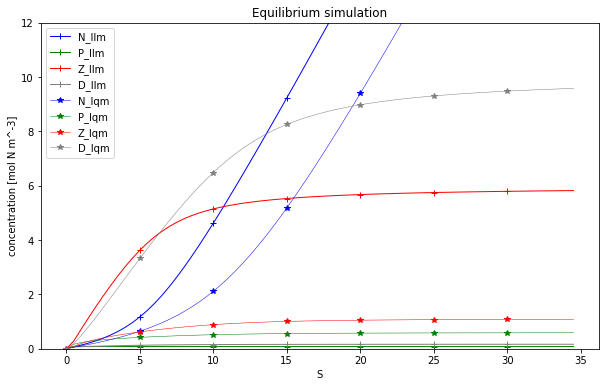

In [79]:
plt.figure(figsize=(10, 6))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_llm, name='llm', marker='+', every=10, lw=1)

# Plot lqm
plot_npzd(ixs, convs_lqm, name='lqm', marker='*', every=10, lw=0.5)

# Labels
plt.title('Equilibrium simulation')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

## Light intensity modelling


Text(0, 0.5, 'Attenuation')

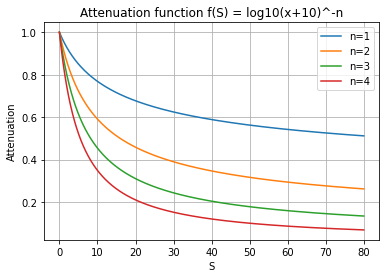

In [80]:
# PLOT FUNCION S
S = np.linspace(0,80,1000)
for i in range(1,5) : plt.plot(S, np.log10(S+10)**-i, label=f'n={i}')
plt.legend()
plt.grid(True)
plt.title('Attenuation function f(S) = log10(x+10)^-n')
plt.xlabel('S')
plt.ylabel('Attenuation')

(0.0, 1.5)

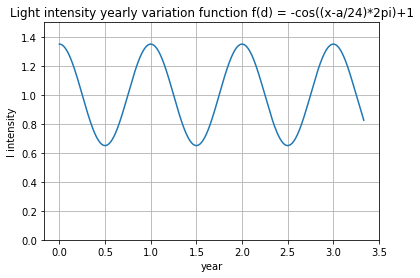

In [81]:
# PLOT FUNCION I DIA
a = 0
day = np.linspace(0,1200,1000)
res = 0.35*np.cos(day*2*np.pi/360)+1
plt.plot(day/360,res)
plt.grid(True)
plt.title('Light intensity yearly variation function f(d) = -cos((x-a/24)*2pi)+1')
plt.xlabel('year')
plt.ylabel('I intensity')
plt.ylim(0,1.5)

Text(0, 0.5, 'I intensity')

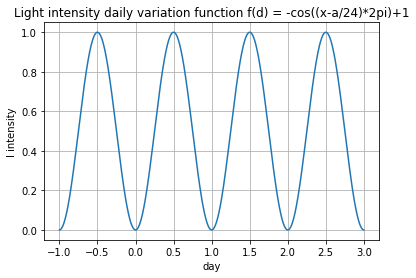

In [82]:
# PLOT FUNCION I DIA
a= 0
day = np.linspace(-1,3,1000)
res = (-np.cos((day-a/24)*2*3.14)+1)/2
plt.plot(day,res)
plt.grid(True)
plt.title('Light intensity daily variation function f(d) = -cos((x-a/24)*2pi)+1')
plt.xlabel('day')
plt.ylabel('I intensity')

In [89]:
# SIMULACION CON FUNCION LOG10 N=1
def phyto_growth2(mum,kn,ki,N,I,S):
    #print(S)
    return mum*(N/(kn+N))*np.log10(S+10)**(-1)

def llm_model2(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth2(mum,kn,ki,X[0],I,np.sum(X))
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

In [92]:
ixs = np.arange(0.01, 35, 0.5)
convs_llm = compute_equilibrium(llm_model, ixs)
convs_llm2 = compute_equilibrium(llm_model2, ixs)

0.0
1.2207169215537538e-05
1.2207169215537538e-05
2.4414338431075075e-05
2.4414338431075075e-05
0.12209610649380645
0.12209610649380645
0.2441677986491818
0.2441677986491818
0.3662394908045572
0.3662394908045572
1.5869564123583109
1.5869564123583109
2.8076733339120645
2.8076733339120645
4.028390255465818
4.028390255465818
5.249107177019572
5.249107177019572
7.692225381386338
7.692225381386338
10.135343585753105
10.135343585753105
12.578461790119873
12.578461790119873
15.02157999448664
15.02157999448664
17.464698198853405
17.464698198853405
22.139299063032347
22.139299063032347
26.81389992721129
26.81389992721129
31.48850079139023
31.48850079139023
30.623276202158067
30.623276202158067
34.432652477104845
34.432652477104845
38.242028752051624
38.242028752051624
42.0514050269984
42.0514050269984
45.86078130194518
45.86078130194518
49.67015757689196
49.67015757689196
54.96991280128889
54.96991280128889
60.269668025685824
60.269668025685824
65.56942325008275
65.56942325008275
70.86917847447

175.66331133281318
179.1134904113627
179.1134904113627
182.56366948991223
182.56366948991223
186.01384856846175
186.01384856846175
189.46402764701128
189.46402764701128
194.98159358398664
194.98159358398664
200.499159520962
200.499159520962
206.01672545793735
206.01672545793735
211.5342913949127
211.5342913949127
217.05185733188807
217.05185733188807
226.63706387218136
226.63706387218136
236.22227041247464
236.22227041247464
245.80747695276793
245.80747695276793
255.3926834930612
255.3926834930612
264.97789003335447
264.97789003335447
264.97789003335447
274.5630965736477
274.5630965736477
274.5630965736477
276.80633014263265
276.80633014263265
279.04956371161757
279.04956371161757
281.2927972806025
281.2927972806025
283.5360308495874
283.5360308495874
285.7792644185723
285.7792644185723
289.9177937876466
289.9177937876466
294.05632315672085
294.05632315672085
298.1948525257951
298.1948525257951
302.3333818948694
302.3333818948694
306.3486190134868
306.3486190134868
310.3638561321043
31

30.97667338186502
32.093769847770716
32.093769847770716
33.21086631367641
33.21086631367641
34.32796277958211
34.32796277958211
35.445059245487805
35.445059245487805
36.5621557113935
36.5621557113935
37.6792521772992
37.6792521772992
38.898905190083376
38.898905190083376
40.118558202867554
40.118558202867554
41.33821121565173
41.33821121565173
42.55786422843591
42.55786422843591
43.77751724122009
43.77751724122009
44.99717025400427
44.99717025400427
46.393043775246795
46.393043775246795
47.78891729648932
47.78891729648932
49.18479081773185
49.18479081773185
50.58066433897438
50.58066433897438
51.97653786021691
51.97653786021691
53.372411381459436
53.372411381459436
55.20082136088581
55.20082136088581
57.02923134031219
57.02923134031219
58.85764131973856
58.85764131973856
60.68605129916494
60.68605129916494
62.51446127859131
62.51446127859131
64.3428712580177
64.3428712580177
65.95454962299098
65.95454962299098
67.56622798796427
67.56622798796427
69.17790635293755
69.17790635293755
70.7

4.291852732382909
4.472301009838934
4.472301009838934
4.6527492872949585
4.6527492872949585
4.833197564750983
4.833197564750983
5.0427703930542656
5.0427703930542656
5.252343221357548
5.252343221357548
5.4619160496608306
5.4619160496608306
5.671488877964113
5.671488877964113
5.8810617062673956
5.8810617062673956
6.090634534570678
6.090634534570678
6.3002073628739605
6.3002073628739605
6.584206449931717
6.584206449931717
6.868205536989473
6.868205536989473
7.152204624047229
7.152204624047229
7.4362037111049855
7.4362037111049855
7.720202798162742
7.720202798162742
8.004201885220498
8.004201885220498
8.288200972278254
8.288200972278254
8.651304278947178
8.651304278947178
9.014407585616102
9.014407585616102
9.377510892285025
9.377510892285025
9.74061419895395
9.74061419895395
10.103717505622873
10.103717505622873
10.466820812291797
10.466820812291797
10.82992411896072
10.82992411896072
11.317820880021406
11.317820880021406
11.805717641082092
11.805717641082092
12.293614402142778
12.293614

393.8777842987306
393.8777842987306
406.8925417998384
406.8925417998384
419.9072993009462
419.9072993009462
419.9072993009462
410.14623117511536
410.14623117511536
413.3999205503923
413.3999205503923
416.6536099256693
416.6536099256693
418.69881610984254
418.69881610984254
436.6038594111695
436.6038594111695
436.6038594111695
436.6038594111695
436.6038594111695
436.6038594111695
454.5089027124964
454.5089027124964
472.41394601382336
504.94226662963615
504.94226662963615
504.94226662963615
504.94226662963615
504.94226662963615
504.94226662963615
537.4705872454489
537.4705872454489
569.9989078612616
733.9690927532175
733.9690927532175
733.9690927532175
733.9690927532175
733.9690927532175
897.9392776451734
1969.0691147405198
1969.0691147405198
1969.0691147405198
1969.0691147405198
1969.0691147405198
3040.198951835866
13751.49732278933
13751.49732278933
13751.49732278933
13751.49732278933
13751.49732278933
0.0
1.2199114488202552e-05
1.2199114488202552e-05
2.4398228976405103e-05
2.439822897

36.985242098735355
36.985242098735355
38.76620526631905
38.76620526631905
40.54716843390274
40.54716843390274
42.32813160148643
42.32813160148643
44.109094769070126
44.109094769070126
45.89005793665382
45.89005793665382
47.67102110423751
47.67102110423751
48.78467448657604
48.78467448657604
49.89832786891456
49.89832786891456
51.01198125125309
51.01198125125309
52.125634633591616
52.125634633591616
53.23928801593014
53.23928801593014
54.35294139826867
54.35294139826867
55.38961210012822
55.38961210012822
56.42628280198777
56.42628280198777
57.46295350384732
57.46295350384732
58.499624205706866
58.499624205706866
59.536294907566415
59.536294907566415
60.804934307260744
60.804934307260744
62.073573706955074
62.073573706955074
63.3422131066494
63.3422131066494
64.61085250634373
64.61085250634373
65.87949190603806
65.87949190603806
68.23173229982345
68.23173229982345
70.58397269360884
70.58397269360884
72.93621308739424
72.93621308739424
75.28845348117963
75.28845348117963
77.6406938749650

39704.15859441159
39704.15859441159
39704.15859441159
39704.15859441159
39704.15859441159
0.0
1.2188748424098823e-05
1.2188748424098823e-05
2.4377496848197645e-05
2.4377496848197645e-05
0.0045462572963987005
0.0045462572963987005
0.009068137095949204
0.009068137095949204
0.013590016895499706
0.013590016895499706
0.02580746102352348
0.02580746102352348
0.03802490515154725
0.03802490515154725
0.050242349279571025
0.050242349279571025
0.0624597934075948
0.0624597934075948
0.08936346779418329
0.08936346779418329
0.0837890893447101
0.0837890893447101
0.1051183852818254
0.1051183852818254
0.1264476812189407
0.1264476812189407
0.147776977156056
0.147776977156056
0.1691062730931713
0.1691062730931713
0.211174174069403
0.211174174069403
0.25324207504563473
0.25324207504563473
0.24455871164065707
0.24455871164065707
0.27794324921191116
0.27794324921191116
0.31132778678316525
0.31132778678316525
0.3041890965387524
0.3041890965387524
0.3304349438655937
0.3304349438655937
0.35668079119243495
0.3566

0.4426768958345428
0.4630842792197778
0.4630842792197778
0.4834916626050128
0.4834916626050128
0.5226505519538854
0.5226505519538854
0.5111436181662053
0.5111436181662053
0.538795573727398
0.538795573727398
0.5664475292885905
0.5664475292885905
0.5615650051131402
0.5615650051131402
0.5843344364988825
0.5843344364988825
0.6071038678846248
0.6071038678846248
0.6298732992703671
0.6298732992703671
0.6526427306561093
0.6526427306561093
0.6754121620418516
0.6754121620418516
0.718988629929452
0.718988629929452
0.7625650978170524
0.7625650978170524
0.7533659491187534
0.7533659491187534
0.7877432683080549
0.7877432683080549
0.7801074023394167
0.7801074023394167
0.8068488555600799
0.8068488555600799
0.8335903087807431
0.8335903087807431
0.8603317620014064
0.8603317620014064
0.8870732152220696
0.8870732152220696
0.9138146684427328
0.9138146684427328
0.9405561216633961
0.9405561216633961
0.9812120196649196
0.9812120196649196
1.021867917666443
1.021867917666443
1.0625238156679664
1.0625238156679664

34.47993238146039
34.47993238146039
36.07886257737967
36.07886257737967
37.67779277329895
37.67779277329895
39.27672296921823
39.27672296921823
40.87565316513751
40.87565316513751
41.760341653934155
41.760341653934155
42.6450301427308
42.6450301427308
43.52971863152745
43.52971863152745
44.4144071203241
44.4144071203241
45.29909560912075
45.29909560912075
46.26041015457425
46.26041015457425
47.22172470002776
47.22172470002776
48.18303924548126
48.18303924548126
49.144353790934765
49.144353790934765
50.10566833638827
50.10566833638827
52.06492459947276
52.06492459947276
54.02418086255726
54.02418086255726
55.98343712564176
55.98343712564176
57.942693388726255
57.942693388726255
59.90194965181075
59.90194965181075
61.86120591489525
61.86120591489525
63.82046217797975
63.82046217797975
65.77971844106425
65.77971844106425
67.73897470414875
67.73897470414875
68.65900289104366
68.65900289104366
69.57903107793857
69.57903107793857
70.49905926483348
70.49905926483348
71.41908745172839
71.41908

564.5329741787925
564.5329741787925
564.5329741787925
590.9153979031223
590.9153979031223
617.2978216274521
617.2978216274521
643.6802453517819
643.6802453517819
670.0626690761117
696.4450928004414
753.758395818059
753.758395818059
753.758395818059
753.758395818059
753.758395818059
753.758395818059
811.0716988356764
811.0716988356764
799.657230102997
799.657230102997
845.5560643879351
891.4548986728731
937.3537329578112
983.2525672427493
1029.1514015276873
1075.0502358126253
1120.9490700975632
1166.8479043825012
1223.9205653353526
1223.9205653353526
1280.9932262882041
1338.0658872410556
1395.1385481939071
1452.2112091467586
1516.3724739791132
1516.3724739791132
1516.3724739791132
1516.3724739791132
1516.3724739791132
1516.3724739791132
1580.5337388114679
1644.6950036438225
1708.856268476177
1958.9472106683536
1958.9472106683536
1958.9472106683536
1958.9472106683536
1958.9472106683536
2209.0381528605303
2459.129095052707
4960.038516974472
4960.038516974472
4960.038516974472
4960.0385169

5420.99011420844
9276.113697796569
47827.34953367786
47827.34953367786
47827.34953367786
47827.34953367786
47827.34953367786
0.0
1.2170815977739341e-05
1.2170815977739341e-05
2.4341631955478683e-05
2.4341631955478683e-05
0.004563949327709121
0.004563949327709121
0.009103557023462765
0.009103557023462765
0.013643164719216408
0.013643164719216408
0.023669787437007837
0.023669787437007837
0.03369641015479927
0.03369641015479927
0.043723032872590696
0.043723032872590696
0.053749655590382125
0.053749655590382125
0.07175531238567438
0.07175531238567438
0.08976096918096664
0.08976096918096664
0.1077666259762589
0.1077666259762589
0.12577228277155117
0.12577228277155117
0.14377793956684343
0.14377793956684343
0.17762059303855895
0.17762059303855895
0.17157709150046757
0.17157709150046757
0.19937624343409172
0.19937624343409172
0.22717539536771586
0.22717539536771586
0.25497454730134
0.25497454730134
0.28277369923496415
0.28277369923496415
0.3105728511685883
0.3105728511685883
0.338372003102212

3.2062756327512587
3.325132359696335
3.325132359696335
3.443989086641411
3.443989086641411
3.5628458135864873
3.5628458135864873
3.6817025405315635
3.6817025405315635
3.8005592674766397
3.8005592674766397
3.919415994421716
3.919415994421716
4.080914748849446
4.080914748849446
4.242413503277177
4.242413503277177
4.403912257704908
4.403912257704908
4.565411012132639
4.565411012132639
4.72690976656037
4.72690976656037
4.888408520988101
4.888408520988101
5.049907275415832
5.049907275415832
5.2721855510034485
5.2721855510034485
5.4944638265910655
5.4944638265910655
5.716742102178682
5.716742102178682
5.939020377766299
5.939020377766299
6.161298653353916
6.161298653353916
6.383576928941533
6.383576928941533
6.60585520452915
6.60585520452915
6.915526941259285
6.915526941259285
7.225198677989419
7.225198677989419
7.5348704147195535
7.5348704147195535
7.844542151449688
7.844542151449688
8.154213888179823
8.154213888179823
8.463885624909958
8.463885624909958
8.773557361640092
8.773557361640092
9

91.85663667307377
91.85663667307377
93.7877078816833
93.7877078816833
95.71877909029284
95.71877909029284
97.64985029890238
97.64985029890238
99.58092150751192
99.58092150751192
102.38075107577322
102.38075107577322
105.18058064403452
105.18058064403452
107.98041021229582
107.98041021229582
110.78023978055712
110.78023978055712
113.58006934881843
113.58006934881843
113.58006934881843
116.37989891707973
116.37989891707973
116.37989891707973
114.2496884296084
114.2496884296084
114.91930751039837
114.91930751039837
115.58892659118834
115.58892659118834
116.25854567197831
116.25854567197831
116.92816475276828
116.92816475276828
117.59778383355825
117.59778383355825
118.45872265171678
118.45872265171678
119.31966146987531
119.31966146987531
120.18060028803384
120.18060028803384
121.04153910619237
121.04153910619237
121.9024779243509
121.9024779243509
122.95423199746193
122.95423199746193
124.00598607057296
124.00598607057296
125.05774014368399
125.05774014368399
126.10949421679501
126.10949

276.96578764966046
278.4897684548279
278.4897684548279
279.5696008553388
279.5696008553388
280.6494332558497
280.6494332558497
281.7292656563606
281.7292656563606
286.59592063823453
286.59592063823453
291.46257562010845
291.46257562010845
296.3292306019824
296.3292306019824
296.3292306019824
292.67923936557696
292.67923936557696
293.89590311104547
293.89590311104547
295.112566856514
295.112566856514
296.3292306019825
296.3292306019825
297.4147314399539
297.4147314399539
298.50023227792536
298.50023227792536
299.5857331158968
299.5857331158968
300.666730341781
300.666730341781
301.74772756766515
301.74772756766515
302.8287247935493
302.8287247935493
309.7714292814353
309.7714292814353
316.7141337693213
316.7141337693213
323.65683825720726
323.65683825720726
323.65683825720726
318.4498098912928
318.4498098912928
320.18548601326427
320.18548601326427
321.92116213523576
321.92116213523576
325.39251437917875
325.39251437917875
325.39251437917875
325.39251437917875
325.39251437917875
325.392

2.4312479756616165e-05
2.4312479756616165e-05
0.004648267037082463
0.004648267037082463
0.009272221594408311
0.009272221594408311
0.01389617615173416
0.01389617615173416
0.023628969664252403
0.023628969664252403
0.03336176317677065
0.03336176317677065
0.043094556689288896
0.043094556689288896
0.05282735020180714
0.05282735020180714
0.0688915991018662
0.0688915991018662
0.08495584800192525
0.08495584800192525
0.10102009690198431
0.10102009690198431
0.11708434580204337
0.11708434580204337
0.1331485947021024
0.1331485947021024
0.15528043031858968
0.15528043031858968
0.17741226593507697
0.17741226593507697
0.19954410155156427
0.19954410155156427
0.22167593716805156
0.22167593716805156
0.24380777278453886
0.24380777278453886
0.26593960840102615
0.26593960840102615
0.3025593418785752
0.3025593418785752
0.33917907535612424
0.33917907535612424
0.32553592658468655
0.32553592658468655
0.3071546588197975
0.3071546588197975
0.31174997576101976
0.31174997576101976
0.31634529270224204
0.316345292702

3.232526587843267
3.3436850945922525
3.3436850945922525
3.454843601341238
3.454843601341238
3.5660021080902236
3.5660021080902236
3.677160614839209
3.677160614839209
3.83323085946911
3.83323085946911
3.989301104099011
3.989301104099011
4.145371348728911
4.145371348728911
4.301441593358812
4.301441593358812
4.457511837988713
4.457511837988713
4.613582082618614
4.613582082618614
4.769652327248515
4.769652327248515
4.925722571878416
4.925722571878416
5.081792816508317
5.081792816508317
5.316811034328828
5.316811034328828
5.551829252149339
5.551829252149339
5.78684746996985
5.78684746996985
6.021865687790362
6.021865687790362
6.256883905610873
6.256883905610873
6.491902123431384
6.491902123431384
6.726920341251895
6.726920341251895
6.961938559072406
6.961938559072406
7.312791209378863
7.312791209378863
7.663643859685321
7.663643859685321
8.014496509991778
8.014496509991778
8.365349160298235
8.365349160298235
8.716201810604693
8.716201810604693
9.06705446091115
9.06705446091115
9.4179071112

149.86699552842887
149.86699552842887
149.86699552842887
146.74368507489135
146.74368507489135
147.40841628497083
147.40841628497083
148.0731474950503
148.0731474950503
148.7378787051298
148.7378787051298
149.40260991520927
149.40260991520927
150.06734112528875
150.06734112528875
150.92159637307012
150.92159637307012
151.77585162085148
151.77585162085148
152.63010686863285
152.63010686863285
153.48436211641422
153.48436211641422
154.33861736419558
154.33861736419558
155.38633823237396
155.38633823237396
156.43405910055233
156.43405910055233
157.4817799687307
157.4817799687307
158.52950083690908
158.52950083690908
159.5481871318035
159.5481871318035
160.56687342669792
160.56687342669792
161.58555972159235
161.58555972159235
162.60424601648677
162.60424601648677
165.79256731910232
165.79256731910232
168.98088862171787
168.98088862171787
172.16920992433342
172.16920992433342
175.35753122694896
175.35753122694896
178.5458525295645
178.5458525295645
182.7254979856612
182.7254979856612
186.9

200.263663344789
200.263663344789
204.29611833510086
204.29611833510086
205.46413376417007
205.46413376417007
206.6321491932393
206.6321491932393
207.8001646223085
207.8001646223085
208.96818005137771
208.96818005137771
210.05466020848496
210.05466020848496
211.1411403655922
211.1411403655922
212.22762052269945
212.22762052269945
215.15117511853876
215.15117511853876
218.07472971437807
218.07472971437807
220.99828431021737
220.99828431021737
223.92183890605668
223.92183890605668
228.05318347321136
228.05318347321136
232.18452804036605
232.18452804036605
232.18452804036605
236.31587260752073
236.31587260752073
236.31587260752073
233.03789288035037
233.03789288035037
233.8912577203347
233.8912577203347
234.74462256031902
234.74462256031902
235.59798740030334
235.59798740030334
236.45135224028766
236.45135224028766
237.49435371137963
237.49435371137963
238.5373551824716
238.5373551824716
239.58035665356357
239.58035665356357
240.62335812465554
240.62335812465554
241.71101149469584
241.711

145.20036629154902
146.25176698887688
146.25176698887688
147.30316768620474
147.30316768620474
148.3545683835326
148.3545683835326
149.3754210830265
149.3754210830265
150.3962737825204
150.3962737825204
151.4171264820143
151.4171264820143
152.4379791815082
152.4379791815082
155.27081882280285
155.27081882280285
158.1036584640975
158.1036584640975
160.93649810539213
160.93649810539213
163.76933774668677
163.76933774668677
166.6021773879814
166.6021773879814
170.25215332347793
170.25215332347793
173.90212925897444
173.90212925897444
177.55210519447095
177.55210519447095
177.55210519447095
174.81462324284857
174.81462324284857
175.7271172267227
175.7271172267227
176.63961121059683
176.63961121059683
177.55210519447095
177.55210519447095
178.46459917834508
178.46459917834508
179.50727485069106
179.50727485069106
180.54995052303704
180.54995052303704
181.59262619538302
181.59262619538302
182.635301867729
182.635301867729
183.69743577885075
183.69743577885075
184.7595696899725
184.7595696899

133.43032516968725
133.43032516968725
131.01406119123743
131.01406119123743
131.68444411025206
131.68444411025206
132.3548270292667
132.3548270292667
133.02520994828132
133.02520994828132
133.69559286729594
133.69559286729594
134.36597578631057
134.36597578631057
135.22737229541883
135.22737229541883
136.0887688045271
136.0887688045271
136.95016531363535
136.95016531363535
137.8115618227436
137.8115618227436
138.67295833185187
138.67295833185187
139.72643304806363
139.72643304806363
140.77990776427538
140.77990776427538
141.83338248048713
141.83338248048713
142.88685719669888
142.88685719669888
144.52460211730107
144.52460211730107
146.16234703790326
146.16234703790326
147.80009195850545
147.80009195850545
149.43783687910764
149.43783687910764
152.1446196392664
152.1446196392664
154.85140239942518
154.85140239942518
157.55818515958396
157.55818515958396
160.26496791974273
160.26496791974273
162.9717506799015
162.9717506799015
165.18459220559805
165.18459220559805
167.3974337312946
167.

94.00827217058301
94.87507904733658
94.87507904733658
95.74188592409016
95.74188592409016
96.60869280084373
96.60869280084373
97.4754996775973
97.4754996775973
98.34230655435087
98.34230655435087
100.43783942020877
100.43783942020877
102.53337228606668
102.53337228606668
104.62890515192458
104.62890515192458
106.72443801778249
106.72443801778249
108.8199708836404
108.8199708836404
110.9155037494983
110.9155037494983
111.78185093836301
111.78185093836301
112.64819812722772
112.64819812722772
113.51454531609242
113.51454531609242
114.38089250495713
114.38089250495713
115.24723969382184
115.24723969382184
116.30497162434908
116.30497162434908
117.36270355487632
117.36270355487632
118.42043548540356
118.42043548540356
119.4781674159308
119.4781674159308
121.51611100843272
121.51611100843272
123.55405460093463
123.55405460093463
125.59199819343655
125.59199819343655
127.62994178593847
127.62994178593847
129.6678853784404
129.6678853784404
132.95444946894764
132.95444946894764
136.2410135594

83.86532684869134
83.86532684869134
86.07399998481311
86.07399998481311
88.28267312093489
88.28267312093489
90.49134625705666
90.49134625705666
92.70001939317844
92.70001939317844
94.90869252930021
94.90869252930021
97.11736566542199
97.11736566542199
97.98628796351304
97.98628796351304
98.85521026160409
98.85521026160409
99.72413255969514
99.72413255969514
100.59305485778619
100.59305485778619
101.46197715587724
101.46197715587724
102.42487002089821
102.42487002089821
103.38776288591919
103.38776288591919
104.35065575094016
104.35065575094016
105.31354861596114
105.31354861596114
107.07463030629063
107.07463030629063
108.83571199662012
108.83571199662012
110.59679368694961
110.59679368694961
112.3578753772791
112.3578753772791
114.11895706760859
114.11895706760859
117.30751252425515
117.30751252425515
120.4960679809017
120.4960679809017
120.4960679809017
123.68462343754825
123.68462343754825
123.68462343754825
121.16963235096532
121.16963235096532
121.84319672102893
121.84319672102893

62.73339816352629
62.73339816352629
63.60907867927674
63.60907867927674
64.4847591950272
64.4847591950272
65.36043971077765
65.36043971077765
66.23612022652812
66.23612022652812
67.11180074227858
67.11180074227858
69.10348373234845
69.10348373234845
71.09516672241833
71.09516672241833
73.0868497124882
73.0868497124882
75.07853270255808
75.07853270255808
77.07021569262795
77.07021569262795
79.06189868269783
79.06189868269783
82.27453704293639
82.27453704293639
85.48717540317494
85.48717540317494
88.6998137634135
88.6998137634135
91.91245212365206
91.91245212365206
95.12509048389062
95.12509048389062
95.12509048389062
92.7156117137117
92.7156117137117
93.51877130377133
93.51877130377133
94.32193089383097
94.32193089383097
95.1250904838906
95.1250904838906
95.92825007395024
95.92825007395024
96.73140966400987
96.73140966400987
97.53456925406951
97.53456925406951
98.21239771702358
98.21239771702358
98.89022617997765
98.89022617997765
99.56805464293171
99.56805464293171
100.24588310588578
1

2.2195495415234894
2.2195495415234894
2.286523553941629
2.286523553941629
2.3534975663597684
2.3534975663597684
2.420471578777908
2.420471578777908
2.511655706429795
2.511655706429795
2.602839834081682
2.602839834081682
2.694023961733569
2.694023961733569
2.785208089385456
2.785208089385456
2.876392217037343
2.876392217037343
2.96757634468923
2.96757634468923
3.058760472341117
3.058760472341117
3.1844186921504885
3.1844186921504885
3.31007691195986
3.31007691195986
3.4357351317692317
3.4357351317692317
3.5613933515786034
3.5613933515786034
3.687051571387975
3.687051571387975
3.8127097911973467
3.8127097911973467
3.9383680110067183
3.9383680110067183
4.113589564112317
4.113589564112317
4.288811117217915
4.288811117217915
4.464032670323514
4.464032670323514
4.639254223429112
4.639254223429112
4.81447577653471
4.81447577653471
4.989697329640308
4.989697329640308
5.164918882745907
5.164918882745907
5.412147161776627
5.412147161776627
5.659375440807347
5.659375440807347
5.906603719838067
5.

0.8150383228751822
0.8150383228751822
0.8315505566017916
0.8315505566017916
0.8480627903284009
0.8480627903284009
0.8645750240550103
0.8645750240550103
0.8810872577816197
0.8810872577816197
0.897599491508229
0.897599491508229
0.9141117252348384
0.9141117252348384
0.9306239589614478
0.9306239589614478
0.9543680720727036
0.9543680720727036
0.9781121851839594
0.9781121851839594
1.0018562982952153
1.0018562982952153
1.0256004114064712
1.0256004114064712
1.049344524517727
1.049344524517727
1.073088637628983
1.073088637628983
1.096832750740239
1.096832750740239
1.1205768638514948
1.1205768638514948
1.1569164905194291
1.1569164905194291
1.1932561171873635
1.1932561171873635
1.2295957438552978
1.2295957438552978
1.2659353705232321
1.2659353705232321
1.3022749971911665
1.3022749971911665
1.3386146238591008
1.3386146238591008
1.3749542505270351
1.3749542505270351
1.4112938771949695
1.4112938771949695
1.4476335038629038
1.4476335038629038
1.4967856475588384
1.4967856475588384
1.545937791254773
1.

0.15125353218425186
0.17006992890045391
0.17006992890045391
0.18888632561665597
0.18888632561665597
0.20770272233285803
0.20770272233285803
0.22651911904906008
0.22651911904906008
0.24533551576526214
0.24533551576526214
0.2641519124814642
0.2641519124814642
0.28296830919766625
0.28296830919766625
0.3017847059138683
0.3017847059138683
0.323103207218737
0.323103207218737
0.34442170852360565
0.34442170852360565
0.3657402098284743
0.3657402098284743
0.3607635005686548
0.3607635005686548
0.37710529261370396
0.37710529261370396
0.3934470846587531
0.3934470846587531
0.40978887670380226
0.40978887670380226
0.4261306687488514
0.4261306687488514
0.4231832455803983
0.4231832455803983
0.4365776144569944
0.4365776144569944
0.44997198333359045
0.44997198333359045
0.4633663522101865
0.4633663522101865
0.4767607210867826
0.4767607210867826
0.49015508996337864
0.49015508996337864
0.5035494588399747
0.5035494588399747
0.501117145330278
0.501117145330278
0.5120792006971773
0.5120792006971773
0.5230412560

0.24509125750834312
0.263829740220365
0.263829740220365
0.2825682229323868
0.2825682229323868
0.30130670564440865
0.30130670564440865
0.3200451883564305
0.3200451883564305
0.3387836710684523
0.3387836710684523
0.35752215378047414
0.35752215378047414
0.37626063649249597
0.37626063649249597
0.3949991192045178
0.3949991192045178
0.3896159142023495
0.3896159142023495
0.402971191912203
0.402971191912203
0.4163264696220565
0.4163264696220565
0.4163264696220565
0.4163264696220565
0.4056422474541737
0.4056422474541737
0.40831330299614443
0.40831330299614443
0.41098435853811516
0.41098435853811516
0.4136554140800859
0.4136554140800859
0.4163264696220566
0.4163264696220566
0.421668580705998
0.421668580705998
0.4270106917899394
0.4270106917899394
0.4323528028738808
0.4323528028738808
0.4376949139578222
0.4376949139578222
0.44303702504176357
0.44303702504176357
0.44837913612570496
0.44837913612570496
0.4619130984696098
0.4619130984696098
0.4754470608135147
0.4754470608135147
0.48898102315741954
0.

0.7135679455567376
0.7135679455567376
0.710295072330629
0.710295072330629
0.7198528304583861
0.7198528304583861
0.7294105885861432
0.7294105885861432
0.7389683467139002
0.7389683467139002
0.7485261048416573
0.7485261048416573
0.76567671602786
0.76567671602786
0.7607332992711127
0.7607332992711127
0.772940493700568
0.772940493700568
0.7851476881300234
0.7851476881300234
0.7973548825594788
0.7973548825594788
0.8095620769889342
0.8095620769889342
0.8217692714183896
0.8217692714183896
0.8397158625308234
0.8397158625308234
0.8576624536432573
0.8576624536432573
0.8756090447556912
0.8756090447556912
0.8935556358681251
0.8935556358681251
0.911502226980559
0.911502226980559
0.929448818092993
0.929448818092993
0.9473954092054269
0.9473954092054269
0.9693087406137846
0.9693087406137846
0.9912220720221423
0.9912220720221423
1.0131354034305
1.0131354034305
1.0350487348388577
1.0350487348388577
1.0569620662472154
1.0569620662472154
1.0788753976555732
1.0788753976555732
1.1007887290639309
1.100788729

1037.3084424346187
1037.3084424346187
1037.3084424346187
1037.3084424346187
1109.9620985027814
1182.615754570944
1546.0547350064176
1546.0547350064176
1546.0547350064176
1546.0547350064176
1546.0547350064176
1909.4937154418908
5543.883519796624
5543.883519796624
5543.883519796624
5543.883519796624
5543.883519796624
9178.273324151356
45522.17136769869
45522.17136769869
45522.17136769869
45522.17136769869
45522.17136769869
0.0
1.2131334859511032e-05
1.2131334859511032e-05
2.4262669719022063e-05
2.4262669719022063e-05
0.0031874892495905725
0.0031874892495905725
0.006350715829462123
0.006350715829462123
0.009513942409333674
0.009513942409333674
0.02087081657759008
0.02087081657759008
0.018817297886858375
0.018817297886858375
0.028120653364383078
0.028120653364383078
0.03742400884190778
0.03742400884190778
0.04672736431943249
0.04672736431943249
0.06282297813548007
0.06282297813548007
0.07891859195152766
0.07891859195152766
0.09501420576757524
0.09501420576757524
0.11110981958362283
0.11110

427.10454683201334
427.10454683201334
428.2466340932259
428.2466340932259
432.47001257920346
432.47001257920346
436.693391065181
436.693391065181
440.91676955115855
440.91676955115855
440.91676955115855
445.1401480371361
445.1401480371361
445.1401480371361
441.9726141726529
441.9726141726529
443.0284587941473
443.0284587941473
444.08430341564167
444.08430341564167
445.14014803713604
445.14014803713604
446.2756245824526
446.2756245824526
447.4111011277692
447.4111011277692
448.5465776730858
448.5465776730858
449.6176520341948
449.6176520341948
450.68872639530383
450.68872639530383
451.75980075641286
451.75980075641286
459.1753605707889
459.1753605707889
466.5909203851649
466.5909203851649
474.00648019954093
474.00648019954093
474.00648019954093
468.4448103387589
468.4448103387589
470.29870029235286
470.29870029235286
472.15259024594684
472.15259024594684
474.0064801995408
474.0064801995408
475.13613464827625
475.13613464827625
476.2657890970117
476.2657890970117
477.3954435457471
477.39

269.01011018441864
269.01011018441864
270.099042358942
270.099042358942
271.1879745334653
271.1879745334653
272.27690670798864
272.27690670798864
277.8847088985625
277.8847088985625
283.49251108913637
283.49251108913637
283.49251108913637
279.286659446206
279.286659446206
280.68860999384947
280.68860999384947
282.09056054149295
282.09056054149295
283.4925110891364
283.4925110891364
284.8944616367799
284.8944616367799
285.98578659833515
285.98578659833515
287.0771115598904
287.0771115598904
288.16843652144564
288.16843652144564
289.2597614830009
289.2597614830009
290.3601511247684
290.3601511247684
291.46054076653587
291.46054076653587
292.56093040830336
292.56093040830336
295.8755878739992
295.8755878739992
299.1902453396951
299.1902453396951
302.50490280539094
302.50490280539094
305.8195602710868
305.8195602710868
311.71711787911653
311.71711787911653
317.61467548714626
317.61467548714626
317.61467548714626
313.19150728112396
313.19150728112396
314.6658966831314
314.6658966831314
316.

195.10931374409486
195.10931374409486
196.17119465931202
196.17119465931202
197.23307557452918
197.23307557452918
198.32416401966324
198.32416401966324
199.4152524647973
199.4152524647973
200.50634090993137
200.50634090993137
201.59742935506543
201.59742935506543
204.97964021674937
204.97964021674937
208.36185107843332
208.36185107843332
211.74406194011726
211.74406194011726
215.1262728018012
215.1262728018012
218.50848366348515
218.50848366348515
219.54764006032158
219.54764006032158
220.58679645715802
220.58679645715802
221.62595285399445
221.62595285399445
222.66510925083088
222.66510925083088
223.65680753592568
223.65680753592568
224.64850582102048
224.64850582102048
225.64020410611528
225.64020410611528
226.63190239121008
226.63190239121008
229.96010957757258
229.96010957757258
233.2883167639351
233.2883167639351
236.6165239502976
236.6165239502976
239.9447311366601
239.9447311366601
243.2729383230226
243.2729383230226
244.4330724031849
244.4330724031849
245.5932064833472
245.5932

105.1935665099487
105.89292543527853
105.89292543527853
106.59228436060836
106.59228436060836
107.29164328593819
107.29164328593819
108.19079240055017
108.19079240055017
109.08994151516214
109.08994151516214
109.98909062977411
109.98909062977411
110.88823974438608
110.88823974438608
111.78738885899806
111.78738885899806
112.79060295968137
112.79060295968137
113.79381706036467
113.79381706036467
114.79703116104798
114.79703116104798
115.80024526173129
115.80024526173129
117.62936869352397
117.62936869352397
119.45849212531665
119.45849212531665
121.28761555710933
121.28761555710933
123.11673898890201
123.11673898890201
124.9458624206947
124.9458624206947
127.94118199385301
127.94118199385301
130.9365015670113
130.9365015670113
133.9318211401696
133.9318211401696
136.9271407133279
136.9271407133279
136.9271407133279
139.9224602864862
139.9224602864862
139.9224602864862
137.626412392973
137.626412392973
138.32568407261812
138.32568407261812
139.02495575226322
139.02495575226322
139.724227

16.942306804056194
17.69522962320111
17.69522962320111
18.44815244234603
18.44815244234603
19.201075261490946
19.201075261490946
19.953998080635863
19.953998080635863
20.70692089978078
20.70692089978078
21.637210016383577
21.637210016383577
22.567499132986374
22.567499132986374
23.49778824958917
23.49778824958917
24.428077366191967
24.428077366191967
25.358366482794764
25.358366482794764
26.629747630869215
26.629747630869215
27.901128778943665
27.901128778943665
29.172509927018115
29.172509927018115
30.443891075092566
30.443891075092566
31.715272223167016
31.715272223167016
32.98665337124147
32.98665337124147
33.94095756332832
33.94095756332832
34.89526175541517
34.89526175541517
35.84956594750202
35.84956594750202
36.803870139588874
36.803870139588874
37.758174331675725
37.758174331675725
38.886373297368586
38.886373297368586
40.014572263061446
40.014572263061446
41.142771228754306
41.142771228754306
42.270970194447166
42.270970194447166
43.399169160140026
43.399169160140026
45.045550

0.6382268534814555
0.6467532370050946
0.6467532370050946
0.6552796205287337
0.6552796205287337
0.6638060040523728
0.6638060040523728
0.6808587710996511
0.6808587710996511
0.6979115381469294
0.6979115381469294
0.6939534506734681
0.6939534506734681
0.7070481302472852
0.7070481302472852
0.7201428098211022
0.7201428098211022
0.7332374893949193
0.7332374893949193
0.7463321689687363
0.7463321689687363
0.7594268485425534
0.7594268485425534
0.7725215281163704
0.7725215281163704
0.7856162076901875
0.7856162076901875
0.8021151779482425
0.8021151779482425
0.8186141482062975
0.8186141482062975
0.8351131184643525
0.8351131184643525
0.8516120887224076
0.8516120887224076
0.8681110589804626
0.8681110589804626
0.8846100292385176
0.8846100292385176
0.9011089994965726
0.9011089994965726
0.9176079697546277
0.9176079697546277
0.9403301865712671
0.9403301865712671
0.9630524033879065
0.9630524033879065
0.985774620204546
0.985774620204546
1.0084968370211853
1.0084968370211853
1.0312190538378248
1.031219053837

777.9210905393788
777.9210905393788
777.9210905393788
802.1329360929127
826.3447816464466
826.3447816464466
850.5566271999804
850.5566271999804
874.7684727535143
912.8142104192533
912.8142104192533
912.8142104192533
912.8142104192533
912.8142104192533
950.8599480849923
988.9056857507313
1026.9514234164703
1112.590136761588
1112.590136761588
1112.590136761588
1112.590136761588
1112.590136761588
1198.2288501067055
1283.8675634518231
2020.8315894763623
2020.8315894763623
2020.8315894763623
2020.8315894763623
2020.8315894763623
2020.8315894763623
2757.7956155009015
2757.7956155009015
3494.7596415254407
9669.38526871187
9669.38526871187
9669.38526871187
9669.38526871187
9669.38526871187
15844.0108958983
0.0
1.2124918076151495e-05
1.2124918076151495e-05
2.424983615230299e-05
2.424983615230299e-05
0.0029891094036889323
0.0029891094036889323
0.005953968971225562
0.005953968971225562
0.008918828538762191
0.008918828538762191
0.021322588005969305
0.021322588005969305
0.018236534531228962
0.01823

386.0793214977351
387.84165209395326
387.84165209395326
388.95556402965906
388.95556402965906
390.06947596536486
390.06947596536486
391.18338790107066
391.18338790107066
392.29729983677646
392.29729983677646
393.4592425555478
393.4592425555478
394.62118527431915
394.62118527431915
395.7831279930905
395.7831279930905
400.6201760686696
400.6201760686696
405.4572241442487
405.4572241442487
410.2942722198278
410.2942722198278
415.1313202954069
415.1313202954069
422.92500789389874
422.92500789389874
430.71869549239057
430.71869549239057
430.71869549239057
424.8734297935217
424.8734297935217
426.8218516931447
426.8218516931447
428.7702735927677
428.7702735927677
430.7186954923907
430.7186954923907
432.66711739201367
432.66711739201367
433.7812213157168
433.7812213157168
434.8953252394199
434.8953252394199
436.009429163123
436.009429163123
437.1235330868261
437.1235330868261
438.28805908397305
438.28805908397305
439.45258508112
439.45258508112
440.61711107826693
440.61711107826693
442.8625886

220.69989782499542
221.8089230830081
221.8089230830081
222.94022564553555
222.94022564553555
224.071528208063
224.071528208063
225.20283077059045
225.20283077059045
226.3341333331179
226.3341333331179
230.3277616443456
230.3277616443456
234.3213899555733
234.3213899555733
238.315018266801
238.315018266801
242.30864657802869
242.30864657802869
242.30864657802869
239.3134253446079
239.3134253446079
240.31183242241482
240.31183242241482
241.31023950022174
241.31023950022174
242.30864657802866
242.30864657802866
243.30705365583557
243.30705365583557
244.40534891466953
244.40534891466953
245.5036441735035
245.5036441735035
246.60193943233745
246.60193943233745
247.7002346911714
247.7002346911714
248.84264653992005
248.84264653992005
249.9850583886687
249.9850583886687
251.12747023741736
251.12747023741736
252.269882086166
252.269882086166
257.1072250685535
257.1072250685535
261.944568050941
261.944568050941
266.78191103332847
266.78191103332847
271.61925401571597
271.61925401571597
271.6192

56.877057497822705
56.877057497822705
58.59885172223812
58.59885172223812
60.32064594665354
60.32064594665354
62.04244017106896
62.04244017106896
63.76423439548438
63.76423439548438
66.60414014067396
66.60414014067396
69.44404588586355
69.44404588586355
72.28395163105313
72.28395163105313
71.798462055767
71.798462055767
74.15287822567046
74.15287822567046
76.50729439557392
76.50729439557392
78.86171056547738
78.86171056547738
81.21612673538084
81.21612673538084
83.5705429052843
83.5705429052843
85.92495907518776
85.92495907518776
85.92495907518776
86.63726659357474
86.63726659357474
87.34957411196172
87.34957411196172
88.0618816303487
88.0618816303487
88.77418914873567
88.77418914873567
89.48649666712265
89.48649666712265
90.19880418550963
90.19880418550963
91.11457889774594
91.11457889774594
92.03035360998226
92.03035360998226
92.94612832221857
92.94612832221857
93.86190303445488
93.86190303445488
94.7776777466912
94.7776777466912
95.69342799591006
95.69342799591006
96.60917824512892


2.6926444560507345
2.6926444560507345
2.8055753822530543
2.8055753822530543
2.918506308455374
2.918506308455374
3.0314372346576937
3.0314372346576937
3.1443681608600134
3.1443681608600134
3.257299087062333
3.257299087062333
3.3702300132646528
3.3702300132646528
3.4831609394669725
3.4831609394669725
3.596091865669292
3.596091865669292
3.709022791871612
3.709022791871612
3.880679539613576
3.880679539613576
4.05233628735554
4.05233628735554
4.223993035097504
4.223993035097504
4.395649782839468
4.395649782839468
4.5673065305814315
4.5673065305814315
4.7389632783233955
4.7389632783233955
4.910620026065359
4.910620026065359
5.082276773807323
5.082276773807323
5.359515573908219
5.359515573908219
5.636754374009114
5.636754374009114
5.91399317411001
5.91399317411001
6.191231974210905
6.191231974210905
6.4684707743118
6.4684707743118
6.745709574412696
6.745709574412696
7.022948374513591
7.022948374513591
7.300187174614487
7.300187174614487
7.669270794196648
7.669270794196648
8.03835441377881
8.0

0.31589395952405447
0.32868134496099266
0.32868134496099266
0.34146873039793085
0.34146873039793085
0.35425611583486905
0.35425611583486905
0.36704350127180724
0.36704350127180724
0.37983088670874543
0.37983088670874543
0.3926182721456836
0.3926182721456836
0.4054056575826218
0.4054056575826218
0.41819304301956
0.41819304301956
0.41508993136793876
0.41508993136793876
0.4247742051532557
0.4247742051532557
0.43445847893857265
0.43445847893857265
0.4343692823433321
0.4343692823433321
0.42669322059127096
0.42669322059127096
0.4286122360292862
0.4286122360292862
0.4305312514673015
0.4305312514673015
0.43245026690531674
0.43245026690531674
0.434369282343332
0.434369282343332
0.43820731321936257
0.43820731321936257
0.44204534409539314
0.44204534409539314
0.4458833749714237
0.4458833749714237
0.4497214058474543
0.4497214058474543
0.45355943672348487
0.45355943672348487
0.45739746759951544
0.45739746759951544
0.46822401471696834
0.46822401471696834
0.47905056183442124
0.47905056183442124
0.4771

859.2185807234363
859.2185807234363
859.2185807234363
859.2185807234363
859.2185807234363
903.8149647029267
903.8149647029267
893.4457757107737
893.4457757107737
927.672970698111
961.9001656854484
996.1273606727858
1030.3545556601232
1064.5817506474605
1098.8089456347977
1133.036140622135
1167.2633356094723
1218.9003417757476
1218.9003417757476
1270.537347942023
1322.1743541082983
1373.8113602745736
1425.448366440849
1425.448366440849
1418.4110523352963
1418.4110523352963
1382.7312986867182
1382.7312986867182
1382.7312986867182
1382.7312986867182
1382.7312986867182
1382.7312986867182
1391.6512370988628
1391.6512370988628
1400.5711755110074
1409.491113923152
1418.4110523352965
1436.2509291595857
1436.2509291595857
1436.2509291595857
1436.2509291595857
1436.2509291595857
1436.2509291595857
1454.0908059838748
1471.930682808164
1489.7705596324531
1574.60388712587
1574.60388712587
1574.60388712587
1574.60388712587
1574.60388712587
1659.4372146192868
1744.2705421127037
2592.6038170468723
259

379.836732295809
380.9368732620863
380.9368732620863
382.0370142283636
382.0370142283636
383.20726450980675
383.20726450980675
384.3775147912499
384.3775147912499
385.54776507269304
385.54776507269304
390.4681738911936
390.4681738911936
395.38858270969416
395.38858270969416
400.3089915281947
400.3089915281947
405.2294003466953
405.2294003466953
408.53022987582517
408.53022987582517
411.83105940495506
411.83105940495506
415.13188893408494
415.13188893408494
415.13188893408494
418.4327184632148
418.4327184632148
418.4327184632148
415.9570963163674
415.9570963163674
416.7823036986499
416.7823036986499
417.6075110809324
417.6075110809324
418.4327184632149
418.4327184632149
419.5729861608224
419.5729861608224
420.7132538584299
420.7132538584299
421.8535215560374
421.8535215560374
425.30589562765005
425.30589562765005
428.7582696992627
428.7582696992627
432.2106437708754
432.2106437708754
435.66301784248805
435.66301784248805
436.7644332885687
436.7644332885687
437.8658487346493
437.86584873

195.55231242298888
196.59704451006053
196.59704451006053
197.64177659713218
197.64177659713218
198.68650868420383
198.68650868420383
202.1512637960537
202.1512637960537
205.6160189079036
205.6160189079036
209.08077401975348
209.08077401975348
209.08077401975348
212.54552913160336
212.54552913160336
212.54552913160336
209.94696279771594
209.94696279771594
210.8131515756784
210.8131515756784
211.67934035364087
211.67934035364087
212.54552913160333
212.54552913160333
213.4117179095658
213.4117179095658
214.54413857184963
214.54413857184963
215.67655923413346
215.67655923413346
216.8089798964173
216.8089798964173
217.94140055870113
217.94140055870113
218.98685626163598
218.98685626163598
220.03231196457082
220.03231196457082
221.07776766750567
221.07776766750567
222.1232233704405
222.1232233704405
226.1210154448835
226.1210154448835
230.1188075193265
230.1188075193265
234.1165995937695
234.1165995937695
238.1143916682125
238.1143916682125
238.1143916682125
235.11604761238027
235.1160476123

93.06006558885308
93.06006558885308
95.68419914069491
95.68419914069491
98.30833269253675
98.30833269253675
100.93246624437859
100.93246624437859
103.55659979622042
103.55659979622042
106.18073334806226
106.18073334806226
106.90544318591282
106.90544318591282
107.63015302376337
107.63015302376337
108.35486286161392
108.35486286161392
109.07957269946448
109.07957269946448
109.80428253731503
109.80428253731503
110.52899237516559
110.52899237516559
111.46086543860315
111.46086543860315
112.39273850204071
112.39273850204071
113.32461156547828
113.32461156547828
114.25648462891584
114.25648462891584
115.1883576923534
115.1883576923534
116.12023075579097
116.12023075579097
117.05210381922853
117.05210381922853
117.9839768826661
117.9839768826661
120.16225413615169
120.16225413615169
122.34053138963728
122.34053138963728
124.51880864312287
124.51880864312287
126.69708589660846
126.69708589660846
128.87536315009405
128.87536315009405
131.05364040357964
131.05364040357964
131.98638308383462
131

2.554655778798141
2.6364628958073877
2.6364628958073877
2.7182700128166344
2.7182700128166344
2.8326207417631335
2.8326207417631335
2.9469714707096326
2.9469714707096326
3.0613221996561317
3.0613221996561317
3.175672928602631
3.175672928602631
3.29002365754913
3.29002365754913
3.404374386495629
3.404374386495629
3.518725115442128
3.518725115442128
3.68046004591326
3.68046004591326
3.842194976384392
3.842194976384392
4.003929906855524
4.003929906855524
4.1656648373266565
4.1656648373266565
4.327399767797789
4.327399767797789
4.489134698268921
4.489134698268921
4.650869628740053
4.650869628740053
4.882404820738881
4.882404820738881
5.113940012737708
5.113940012737708
5.345475204736536
5.345475204736536
5.577010396735363
5.577010396735363
5.808545588734191
5.808545588734191
6.040080780733018
6.040080780733018
6.271615972731846
6.271615972731846
6.607194757419139
6.607194757419139
6.942773542106432
6.942773542106432
7.2783523267937245
7.2783523267937245
7.613931111481017
7.613931111481017


1.0998961918426584
1.0998961918426584
1.1271605026286846
1.1271605026286846
1.1544248134147108
1.1544248134147108
1.181689124200737
1.181689124200737
1.2089534349867632
1.2089534349867632
1.2362177457727894
1.2362177457727894
1.2634820565588156
1.2634820565588156
1.2907463673448418
1.2907463673448418
1.3272839228001176
1.3272839228001176
1.3638214782553935
1.3638214782553935
1.4003590337106693
1.4003590337106693
1.436896589165945
1.436896589165945
1.473434144621221
1.473434144621221
1.5099717000764967
1.5099717000764967
1.5465092555317725
1.5465092555317725
1.5961090342474045
1.5961090342474045
1.6457088129630364
1.6457088129630364
1.6953085916786683
1.6953085916786683
1.7449083703943002
1.7449083703943002
1.7945081491099322
1.7945081491099322
1.844107927825564
1.844107927825564
1.893707706541196
1.893707706541196
1.9618447296834416
1.9618447296834416
2.0299817528256874
2.0299817528256874
2.098118775967933
2.098118775967933
2.1662557991101785
2.1662557991101785
2.234392822252424
2.2343

0.37970403063851077
0.37970403063851077
0.3938632300274326
0.3938632300274326
0.3913671550843689
0.3913671550843689
0.4030302795302271
0.4030302795302271
0.41469340397608523
0.41469340397608523
0.4263565284219434
0.4263565284219434
0.42612105764969754
0.42612105764969754
0.4169789347108077
0.4169789347108077
0.4192644654455302
0.4192644654455302
0.4215499961802527
0.4215499961802527
0.42383552691497517
0.42383552691497517
0.42612105764969765
0.42612105764969765
0.42840658838442014
0.42840658838442014
0.43297764985386505
0.43297764985386505
0.43754871132330997
0.43754871132330997
0.4421197727927549
0.4421197727927549
0.4466908342621998
0.4466908342621998
0.4512618957316447
0.4512618957316447
0.45583295720108963
0.45583295720108963
0.46040401867053454
0.46040401867053454
0.47002717589678905
0.47002717589678905
0.47965033312304356
0.47965033312304356
0.48927349034929807
0.48927349034929807
0.4869903138252087
0.4869903138252087
0.4943302945273738
0.4943302945273738
0.5016702752295389
0.501

494.9042123137822
494.9042123137822
496.0077865556202
496.0077865556202
502.14572289641836
502.14572289641836
508.2836592372165
508.2836592372165
514.4215955780146
514.4215955780146
514.4215955780146
509.81814332241606
509.81814332241606
511.3526274076156
511.3526274076156
512.8871114928152
512.8871114928152
514.4215955780147
514.4215955780147
515.6351575058561
515.6351575058561
516.8487194336975
516.8487194336975
518.0622813615389
518.0622813615389
523.1135166485708
523.1135166485708
528.1647519356027
528.1647519356027
533.2159872226346
533.2159872226346
539.8776593405847
539.8776593405847
539.8776593405847
539.8776593405847
539.8776593405847
539.8776593405847
546.5393314585349
546.5393314585349
553.201003576485
553.201003576485
559.8626756944352
569.2825525683611
578.702429442287
588.1223063162129
588.1223063162129
597.5421831901388
606.9620600640646
616.3819369379905
625.8018138119164
635.2216906858423
644.6415675597682
643.2561347163713
636.8285794919481
636.8285794919481
636.82857

313.4163080945438
313.4163080945438
314.7437338464425
314.7437338464425
316.07115959834124
316.07115959834124
317.39858535023996
317.39858535023996
318.72601110213867
318.72601110213867
319.8734718613048
319.8734718613048
321.0209326204709
321.0209326204709
322.168393379637
322.168393379637
323.3158541388031
323.3158541388031
324.4239561920916
324.4239561920916
325.53205824538014
325.53205824538014
326.64016029866866
326.64016029866866
329.80704922535574
329.80704922535574
332.9739381520428
332.9739381520428
332.4396455984266
332.4396455984266
335.0722419714974
335.0722419714974
337.70483834456826
337.70483834456826
340.3374347176391
340.3374347176391
345.6026274637808
345.6026274637808
350.86782020992246
350.86782020992246
356.13301295606414
356.13301295606414
356.13301295606414
352.18411839645785
352.18411839645785
353.50041658299324
353.50041658299324
354.81671476952863
354.81671476952863
356.133012956064
356.133012956064
357.4493111425994
357.4493111425994
358.6099255625527
358.609

146.31460788253636
146.31460788253636
148.46199185346381
148.46199185346381
150.60937582439126
150.60937582439126
153.3110878660239
153.3110878660239
156.01279990765656
156.01279990765656
158.7145119492892
158.7145119492892
161.41622399092185
161.41622399092185
164.1179360325545
164.1179360325545
165.61678632681466
165.61678632681466
167.11563662107483
167.11563662107483
168.614486915335
168.614486915335
170.11333720959516
170.11333720959516
171.22522626850466
171.22522626850466
172.33711532741415
172.33711532741415
173.44900438632365
173.44900438632365
174.56089344523315
174.56089344523315
176.5976278489753
176.5976278489753
178.63436225271744
178.63436225271744
180.67109665645958
180.67109665645958
182.70783106020173
182.70783106020173
185.92573358142516
185.92573358142516
189.1436361026486
189.1436361026486
192.36153862387204
192.36153862387204
192.36153862387204
189.94811173295446
189.94811173295446
190.75258736326032
190.75258736326032
191.55706299356618
191.55706299356618
192.361

25.76262372652908
26.735637765837627
26.735637765837627
27.708651805146175
27.708651805146175
28.681665844454724
28.681665844454724
29.654679883763272
29.654679883763272
31.178467438038883
31.178467438038883
32.702254992314494
32.702254992314494
34.22604254659011
34.22604254659011
33.95430306618824
33.95430306618824
35.20635114006198
35.20635114006198
36.45839921393573
36.45839921393573
37.71044728780947
37.71044728780947
38.96249536168322
38.96249536168322
40.21454343555696
40.21454343555696
42.22252824655944
42.22252824655944
44.23051305756192
44.23051305756192
46.2384978685644
46.2384978685644
48.24648267956688
48.24648267956688
50.25446749056936
50.25446749056936
52.26245230157184
52.26245230157184
54.27043711257432
54.27043711257432
55.012665275320536
55.012665275320536
55.75489343806675
55.75489343806675
56.49712160081297
56.49712160081297
57.23934976355918
57.23934976355918
57.9815779263054
57.9815779263054
58.723806089051614
58.723806089051614
59.67718559156106
59.6771855915610

4.461812818448049
4.461812818448049
4.703699366388359
4.703699366388359
4.945585914328669
4.945585914328669
5.187472462268979
5.187472462268979
5.429359010209289
5.429359010209289
5.671245558149599
5.671245558149599
5.913132106089909
5.913132106089909
6.155018654030219
6.155018654030219
6.3969052019705295
6.3969052019705295
6.729659236654145
6.729659236654145
7.0624132713377605
7.0624132713377605
7.395167306021376
7.395167306021376
7.727921340704992
7.727921340704992
8.060675375388607
8.060675375388607
8.393429410072223
8.393429410072223
8.726183444755838
8.726183444755838
9.058937479439454
9.058937479439454
9.557230570440202
9.557230570440202
10.055523661440951
10.055523661440951
10.5538167524417
10.5538167524417
11.052109843442448
11.052109843442448
11.550402934443197
11.550402934443197
12.048696025443945
12.048696025443945
12.546989116444694
12.546989116444694
13.209624167073319
13.209624167073319
13.872259217701941
13.872259217701941
14.534894268330564
14.534894268330564
15.1975293

0.06838907491025019
0.0864105887819145
0.0864105887819145
0.10443210265357881
0.10443210265357881
0.12245361652524313
0.12245361652524313
0.14243855722406112
0.14243855722406112
0.1624234979228791
0.1624234979228791
0.1824084386216971
0.1824084386216971
0.20239337932051507
0.20239337932051507
0.22237832001933305
0.22237832001933305
0.24236326071815104
0.24236326071815104
0.2388157220509232
0.2388157220509232
0.2552531240825133
0.2552531240825133
0.2716905261141035
0.2716905261141035
0.28812792814569366
0.28812792814569366
0.28526477616436163
0.28526477616436163
0.2988390262146198
0.2988390262146198
0.3124132762648779
0.3124132762648779
0.32598752631513606
0.32598752631513606
0.3395617763653942
0.3395617763653942
0.33684231065622483
0.33684231065622483
0.3476970949973136
0.3476970949973136
0.3585518793384024
0.3585518793384024
0.36940666367949115
0.36940666367949115
0.38026144802057993
0.38026144802057993
0.3911162323616687
0.3911162323616687
0.4050560729152856
0.4050560729152856
0.4022

427.603910498031
428.7804034817604
428.7804034817604
429.9568964654898
429.9568964654898
431.1845480358335
431.1845480358335
432.4121996061771
432.4121996061771
433.6398511765208
433.6398511765208
438.39238790136096
438.39238790136096
443.14492462620115
443.14492462620115
447.89746135104133
447.89746135104133
452.6499980758815
452.6499980758815
455.1527032398582
455.1527032398582
457.65540840383494
457.65540840383494
460.15811356781165
460.15811356781165
463.2820663183675
463.2820663183675
466.4060190689234
466.4060190689234
469.5299718194793
469.5299718194793
472.65392457003514
472.65392457003514
473.83357895132195
473.83357895132195
475.01323333260876
475.01323333260876
476.1928877138956
476.1928877138956
477.39447473692655
477.39447473692655
478.59606175995754
478.59606175995754
479.7976487829885
479.7976487829885
484.92096955723105
484.92096955723105
490.0442903314736
490.0442903314736
495.1676111057161
495.1676111057161
500.29093187995863
500.29093187995863
500.29093187995863
496.

25.76843370903271
26.751155044299995
26.751155044299995
27.73387637956728
27.73387637956728
28.716597714834567
28.716597714834567
30.232395009620266
30.232395009620266
31.748192304405965
31.748192304405965
33.26398959919166
33.26398959919166
32.98970243343196
32.98970243343196
34.23121256245795
34.23121256245795
35.47272269148394
35.47272269148394
36.71423282050993
36.71423282050993
37.95574294953592
37.95574294953592
39.19725307856191
39.19725307856191
41.032133553661794
41.032133553661794
42.86701402876168
42.86701402876168
44.70189450386157
44.70189450386157
46.53677497896145
46.53677497896145
48.37165545406134
48.37165545406134
50.20653592916123
50.20653592916123
52.04141640426111
52.04141640426111
52.791064536327085
52.791064536327085
53.540712668393056
53.540712668393056
54.29036080045903
54.29036080045903
55.040008932525
55.040008932525
55.78965706459097
55.78965706459097
56.53930519665694
56.53930519665694
57.502198962995585
57.502198962995585
58.46509272933423
58.4650927293342

0.47893919182389677
0.47893919182389677
0.4859643992723327
0.4859643992723327
0.4842609769932031
0.4842609769932031
0.4895827621625094
0.4895827621625094
0.4949045473318157
0.4949045473318157
0.500226332501122
0.500226332501122
0.5055481176704284
0.5055481176704284
0.5108699028397348
0.5108699028397348
0.5161916880090411
0.5161916880090411
0.5232727886645054
0.5232727886645054
0.5303538893199697
0.5303538893199697
0.537434989975434
0.537434989975434
0.535888562461166
0.535888562461166
0.5414232356023623
0.5414232356023623
0.5469579087435585
0.5469579087435585
0.5524925818847548
0.5524925818847548
0.5580272550259511
0.5580272550259511
0.5635619281671473
0.5635619281671473
0.5690966013083436
0.5690966013083436
0.5782243599711193
0.5782243599711193
0.587352118633895
0.587352118633895
0.5852474776822968
0.5852474776822968
0.5922705953934743
0.5922705953934743
0.5992937131046517
0.5992937131046517
0.6063168308158292
0.6063168308158292
0.6133399485270067
0.6133399485270067
0.6203630662381842

568.9185115797632
568.9185115797632
568.9185115797632
568.9185115797632
572.9784278703755
572.9784278703755
577.0383441609879
581.0982604516003
588.2977142245709
588.2977142245709
588.2977142245709
588.2977142245709
588.2977142245709
588.2977142245709
595.4971679975415
595.4971679975415
602.6966217705121
602.6966217705121
609.8960755434828
621.1371764736372
621.1371764736372
621.1371764736372
621.1371764736372
621.1371764736372
621.1371764736372
632.3782774037916
632.3782774037916
643.619378333946
643.619378333946
654.8604792641004
666.1015801942548
680.1061655063313
694.1107508184078
708.1153361304844
722.1199214425609
736.1245067546374
754.848800770108
754.848800770108
754.848800770108
754.848800770108
754.848800770108
754.848800770108
773.5730947855786
773.5730947855786
792.2973888010492
792.2973888010492
811.0216828165198
811.0216828165198
829.7459768319904
857.0946600388457
857.0946600388457
857.0946600388457
857.0946600388457
857.0946600388457
857.0946600388457
884.443343245701
8

236.81000515156677
237.80683134407445
237.80683134407445
238.993481232427
238.993481232427
240.18013112077955
240.18013112077955
241.3667810091321
241.3667810091321
242.55343089748465
242.55343089748465
243.71818094921252
243.71818094921252
244.8829310009404
244.8829310009404
246.04768105266828
246.04768105266828
247.21243110439616
247.21243110439616
251.3405260709463
251.3405260709463
255.46862103749646
255.46862103749646
259.59671600404664
259.59671600404664
263.7248109705968
263.7248109705968
263.7248109705968
260.6287397456842
260.6287397456842
261.66076348732173
261.66076348732173
262.6927872289593
262.6927872289593
263.7248109705968
263.7248109705968
264.75683471223437
264.75683471223437
265.9370294031622
265.9370294031622
267.1172240940901
267.1172240940901
268.29741878501795
268.29741878501795
269.4776134759458
269.4776134759458
270.6741838327628
270.6741838327628
271.8707541895798
271.8707541895798
273.06732454639683
273.06732454639683
274.26389490321384
274.26389490321384
277

120.22945002355732
120.22945002355732
121.1985462886981
121.1985462886981
122.16764255383887
122.16764255383887
123.13673881897965
123.13673881897965
125.65533140739932
125.65533140739932
128.173923995819
128.173923995819
130.69251658423866
130.69251658423866
133.21110917265833
133.21110917265833
135.729701761078
135.729701761078
138.24829434949766
138.24829434949766
139.2173697476349
139.2173697476349
140.18644514577215
140.18644514577215
141.1555205439094
141.1555205439094
142.12459594204665
142.12459594204665
143.0936713401839
143.0936713401839
144.2780499525332
144.2780499525332
145.4624285648825
145.4624285648825
146.64680717723178
146.64680717723178
147.83118578958107
147.83118578958107
150.0775784011431
150.0775784011431
152.32397101270516
152.32397101270516
154.5703636242672
154.5703636242672
156.81675623582925
156.81675623582925
159.0631488473913
159.0631488473913
161.54614784203972
161.54614784203972
164.02914683668814
164.02914683668814
166.51214583133657
166.51214583133657


5.7207156997432405
5.942321310620862
5.942321310620862
6.265533180666115
6.265533180666115
6.588745050711369
6.588745050711369
6.911956920756622
6.911956920756622
7.235168790801875
7.235168790801875
7.558380660847129
7.558380660847129
7.881592530892382
7.881592530892382
8.204804400937634
8.204804400937634
8.682374627798477
8.682374627798477
9.15994485465932
9.15994485465932
9.637515081520164
9.637515081520164
10.115085308381007
10.115085308381007
10.59265553524185
10.59265553524185
11.070225762102693
11.070225762102693
11.547795988963536
11.547795988963536
12.152447986942382
12.152447986942382
12.75709998492123
12.75709998492123
13.361751982900076
13.361751982900076
13.966403980878923
13.966403980878923
14.57105597885777
14.57105597885777
15.175707976836616
15.175707976836616
15.9524465182976
15.9524465182976
16.729185059758585
16.729185059758585
17.505923601219568
17.505923601219568
18.28266214268055
18.28266214268055
19.059400684141533
19.059400684141533
19.836139225602516
19.8361392

0.3800418722034339
0.3800418722034339
0.3873206113584422
0.3873206113584422
0.3945993505134505
0.3945993505134505
0.40187808966845884
0.40187808966845884
0.40915682882346716
0.40915682882346716
0.4164355679784755
0.4164355679784755
0.4237143071334838
0.4237143071334838
0.43229857412018113
0.43229857412018113
0.4408828411068785
0.4408828411068785
0.4386276807211117
0.4386276807211117
0.44495678732204225
0.44495678732204225
0.4512858939229728
0.4512858939229728
0.4504547377786287
0.4504547377786287
0.4559526882352152
0.4559526882352152
0.454567558840243
0.454567558840243
0.45868037990185734
0.45868037990185734
0.46279320096347165
0.46279320096347165
0.46690602202508596
0.46690602202508596
0.46616376928962916
0.46616376928962916
0.46953433761578667
0.46953433761578667
0.4729049059419442
0.4729049059419442
0.4762754742681017
0.4762754742681017
0.4796460425942592
0.4796460425942592
0.48433566968028985
0.48433566968028985
0.48342693797395064
0.48342693797395064
0.4872078333536421
0.487207833

552.6437051856656
553.8996549288887
553.8996549288887
555.1556046721118
555.1556046721118
556.411554415335
556.411554415335
557.6381116985459
557.6381116985459
558.8646689817568
558.8646689817568
560.0912262649678
560.0912262649678
561.5729807294363
561.5729807294363
563.0547351939048
563.0547351939048
564.5364896583733
564.5364896583733
574.0247393628747
574.0247393628747
583.5129890673761
583.5129890673761
583.5129890673761
576.396801789
576.396801789
578.7688642151254
578.7688642151254
581.1409266412508
581.1409266412508
583.5129890673761
583.5129890673761
584.6932798681775
584.6932798681775
585.8735706689788
585.8735706689788
587.0538614697801
587.0538614697801
588.2494072693822
588.2494072693822
589.4449530689843
589.4449530689843
590.6404988685864
590.6404988685864
596.785277995023
596.785277995023
602.9300571214595
602.9300571214595
609.0748362478961
609.0748362478961
620.6466229923908
620.6466229923908
620.6466229923908
611.9677829340197
611.9677829340197
614.8607296201434
614.

248.74186469286116
248.74186469286116
249.91004630524873
249.91004630524873
251.0782279176363
251.0782279176363
252.27150018885453
252.27150018885453
253.46477246007277
253.46477246007277
254.658044731291
254.658044731291
255.85131700250923
255.85131700250923
259.30541758387636
259.30541758387636
262.7595181652435
262.7595181652435
266.2136187466106
266.2136187466106
269.66771932797775
269.66771932797775
273.1218199093449
273.1218199093449
274.2812177249732
274.2812177249732
275.4406155406015
275.4406155406015
276.60001335622985
276.60001335622985
277.7594111718582
277.7594111718582
278.8136297740266
278.8136297740266
279.867848376195
279.867848376195
280.92206697836343
280.92206697836343
281.97628558053185
281.97628558053185
285.07101931758325
285.07101931758325
288.16575305463465
288.16575305463465
291.26048679168605
291.26048679168605
294.35522052873745
294.35522052873745
297.44995426578885
297.44995426578885
299.0172289982892
299.0172289982892
300.5845037307896
300.5845037307896
30

43.27038266094155
43.27038266094155
45.63058950083431
45.63058950083431
47.99079634072707
47.99079634072707
50.351003180619834
50.351003180619834
52.711210020512596
52.711210020512596
55.07141686040536
55.07141686040536
57.43162370029812
57.43162370029812
59.79183054019088
59.79183054019088
60.5567238799513
60.5567238799513
61.32161721971172
61.32161721971172
62.08651055947214
62.08651055947214
62.85140389923256
62.85140389923256
63.61629723899298
63.61629723899298
64.3811905787534
64.3811905787534
65.36360567360505
65.36360567360505
66.3460207684567
66.3460207684567
67.32843586330834
67.32843586330834
68.31085095815999
68.31085095815999
69.29326605301164
69.29326605301164
70.27557716150775
70.27557716150775
71.25788827000387
71.25788827000387
72.2401993785
72.2401993785
73.22251048699611
73.22251048699611
74.20482159549223
74.20482159549223
76.05525040318389
76.05525040318389
77.90567921087555
77.90567921087555
79.7561080185672
79.7561080185672
81.60653682625886
81.60653682625886
83.4

0.6660351462702284
0.6747396732294981
0.6747396732294981
0.6834442001887678
0.6834442001887678
0.6921487271480375
0.6921487271480375
0.7008532541073073
0.7008532541073073
0.709557781066577
0.709557781066577
0.7182623080258467
0.7182623080258467
0.7291836446191107
0.7291836446191107
0.7401049812123747
0.7401049812123747
0.7510263178056387
0.7510263178056387
0.7619476543989027
0.7619476543989027
0.7728689909921667
0.7728689909921667
0.7837903275854307
0.7837903275854307
0.7947116641786947
0.7947116641786947
0.8083535708386361
0.8083535708386361
0.8219954774985776
0.8219954774985776
0.8356373841585191
0.8356373841585191
0.8492792908184605
0.8492792908184605
0.862921197478402
0.862921197478402
0.8765631041383435
0.8765631041383435
0.890205010798285
0.890205010798285
0.9080566216338259
0.9080566216338259
0.9259082324693669
0.9259082324693669
0.9437598433049079
0.9437598433049079
0.9616114541404489
0.9616114541404489
0.9794630649759899
0.9794630649759899
0.9973146758115309
0.9973146758115309

689.619739082162
704.1037942442017
718.5878494062414
733.0719045682811
747.5559597303208
762.0400148923604
781.5847158734882
781.5847158734882
781.5847158734882
781.5847158734882
781.5847158734882
781.5847158734882
801.129416854616
801.129416854616
820.6741178357438
820.6741178357438
840.2188188168716
840.2188188168716
859.7635197979994
888.7438561320894
888.7438561320894
888.7438561320894
888.7438561320894
888.7438561320894
888.7438561320894
917.7241924661794
917.7241924661794
946.7045288002694
946.7045288002694
975.6848651343594
1004.6652014684494
1055.0971616891359
1055.0971616891359
1055.0971616891359
1055.0971616891359
1055.0971616891359
1105.5291219098224
1155.9610821305089
1206.3930423511954
1381.6277215182508
1381.6277215182508
1381.6277215182508
1381.6277215182508
1381.6277215182508
1556.8624006853063
1732.0970798523617
3484.443871522917
3484.443871522917
3484.443871522917
3484.443871522917
3484.443871522917
5236.790663193473
22760.258579899026
22760.258579899026
22760.2585798

336.8657051421975
336.8657051421975
338.0927378616457
338.0927378616457
339.31977058109385
339.31977058109385
344.1116981709601
344.1116981709601
348.90362576082634
348.90362576082634
353.6955533506926
353.6955533506926
358.48748094055884
358.48748094055884
363.2794085304251
363.2794085304251
363.2794085304251
359.6854628380254
359.6854628380254
360.88344473549193
360.88344473549193
362.0814266329585
362.0814266329585
363.27940853042503
363.27940853042503
364.4773904278916
364.4773904278916
365.66752580606004
365.66752580606004
366.8576611842285
366.8576611842285
368.04779656239697
368.04779656239697
369.23793194056543
369.23793194056543
370.52025271538247
370.52025271538247
371.8025734901995
371.8025734901995
373.08489426501654
373.08489426501654
376.482194975462
376.482194975462
379.87949568590744
379.87949568590744
383.2767963963529
383.2767963963529
386.67409710679834
386.67409710679834
392.6712061016153
392.6712061016153
398.6683150964323
398.6683150964323
398.6683150964323
394.17

17.652007331099526
18.435968360691525
18.435968360691525
19.364790231533533
19.364790231533533
20.29361210237554
20.29361210237554
21.222433973217548
21.222433973217548
22.151255844059555
22.151255844059555
23.080077714901563
23.080077714901563
24.09049079046501
24.09049079046501
25.10090386602846
25.10090386602846
26.11131694159191
26.11131694159191
27.121730017155357
27.121730017155357
28.132143092718806
28.132143092718806
29.6324797619136
29.6324797619136
31.132816431108395
31.132816431108395
32.63315310030319
32.63315310030319
32.00010834959505
32.00010834959505
32.86740026808171
32.86740026808171
33.73469218656837
33.73469218656837
34.601984105055024
34.601984105055024
35.46927602354168
35.46927602354168
37.0043492300179
37.0043492300179
38.53942243649412
38.53942243649412
40.07449564297034
40.07449564297034
39.813949595017334
39.813949595017334
41.08847675354055
41.08847675354055
42.36300391206376
42.36300391206376
43.637531070586974
43.637531070586974
44.91205822911019
44.912058

0.22400983503520536
0.23656463582192724
0.23656463582192724
0.24911943660864913
0.24911943660864913
0.26167423739537105
0.26167423739537105
0.27422903818209293
0.27422903818209293
0.2717282357301535
0.2717282357301535
0.2817822340649359
0.2817822340649359
0.29183623239971834
0.29183623239971834
0.3018902307345008
0.3018902307345008
0.3119442290692832
0.3119442290692832
0.3100883238913088
0.3100883238913088
0.31828641704811683
0.31828641704811683
0.32648451020492486
0.32648451020492486
0.3346826033617329
0.3346826033617329
0.3428806965185409
0.3428806965185409
0.34151244115878215
0.34151244115878215
0.3483422789558314
0.3483422789558314
0.3551721167528807
0.3551721167528807
0.36200195454992995
0.36200195454992995
0.3688317923469792
0.3688317923469792
0.3756616301440285
0.3756616301440285
0.37443958947961026
0.37443958947961026
0.3800473866122413
0.3800473866122413
0.38565518374487234
0.38565518374487234
0.3912629808775034
0.3912629808775034
0.39687077801013443
0.39687077801013443
0.4033

427.07635710066535
427.07635710066535
428.66070234169985
428.66070234169985
430.24504758273434
430.24504758273434
431.4164913420391
431.4164913420391
432.5879351013438
432.5879351013438
433.75937886064855
433.75937886064855
434.9308226199533
434.9308226199533
436.1720093035499
436.1720093035499
437.4131959871465
437.4131959871465
438.6543826707431
438.6543826707431
443.5102489876177
443.5102489876177
448.36611530449227
448.36611530449227
453.22198162136687
453.22198162136687
458.07784793824146
458.07784793824146
465.7742587491937
465.7742587491937
473.4706695601459
473.4706695601459
473.4706695601459
467.6983614519317
467.6983614519317
469.62246415466973
469.62246415466973
471.54656685740775
471.54656685740775
473.4706695601458
473.4706695601458
475.3947722628838
475.3947722628838
476.6152475991437
476.6152475991437
477.83572293540357
477.83572293540357
479.05619827166345
479.05619827166345
480.2766736079233
480.2766736079233
481.5329017397913
481.5329017397913
482.7891298716593
482.78

156.4718370800264
156.4718370800264
156.4718370800264
157.466913372239
157.466913372239
158.46198966445158
158.46198966445158
159.45706595666417
159.45706595666417
160.45214224887675
160.45214224887675
161.44721854108934
161.44721854108934
162.6655096647525
162.6655096647525
163.88380078841567
163.88380078841567
165.10209191207883
165.10209191207883
166.320383035742
166.320383035742
167.52319963958553
167.52319963958553
168.72601624342906
168.72601624342906
169.9288328472726
169.9288328472726
171.13164945111612
171.13164945111612
173.89073628454426
173.89073628454426
176.6498231179724
176.6498231179724
179.40890995140055
179.40890995140055
182.1679967848287
182.1679967848287
184.92708361825683
184.92708361825683
186.14299183625232
186.14299183625232
187.3589000542478
187.3589000542478
188.5748082722433
188.5748082722433
189.7907164902388
189.7907164902388
190.95765109871277
190.95765109871277
192.12458570718675
192.12458570718675
193.29152031566073
193.29152031566073
194.4584549241347


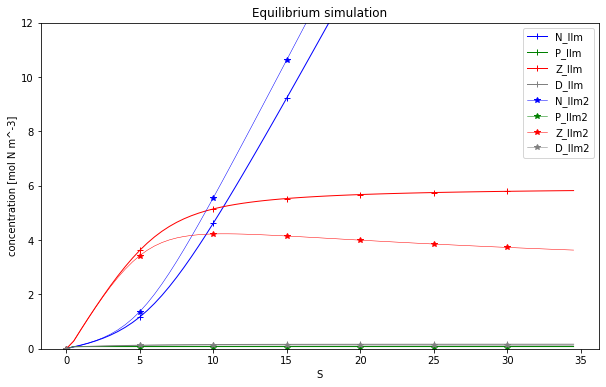

In [91]:
plt.figure(figsize=(10, 6))
plt.ylim(0,12)

# Plot llm
plot_npzd(ixs, convs_llm, name='llm', marker='+', every=10, lw=1)

# Plot lqm
plot_npzd(ixs, convs_llm2, name='llm2', marker='*', every=10, lw=0.5)

# Labels
plt.title('Equilibrium simulation')
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

In [93]:
# SIMULACION CON FUNCION TEMPORAL
def phyto_growth3(mum,kn,ki,N,I,S,t):
    return mum*(N/(kn+N))*(0.35*np.cos(t*2*3.14/360)+1)

def llm_model3(X,t):
    I=parameters['I']
    beta=parameters['beta']
    mum=parameters['mum']
    kn=parameters['kn']
    ki=parameters['ki']
    g=parameters['g']
    epsilon=parameters['epsilon']
    gammam=parameters['gammam']
    phiz=parameters['phiz']
    phip=parameters['phip']
    
    J = phyto_growth3(mum,kn,ki,X[0],I,np.sum(X),t)
    G = grazing_growth(g,epsilon,X[1])
    
    N= -J*X[1]+phiz*X[2]+gammam*X[3] 
    P= (J-phip)*X[1]-G*X[2]
    Z= (beta*G-phiz)*X[2]
    D= phip*X[1]+(1-beta)*G*X[2]-gammam*X[3]
    
    return np.array([N,P,Z,D])

In [101]:
# SINGLE EQUILIBRIUM SIMULATION
S = 2
# Create X0
X = np.array([1,1,1,1])
norm = S/(X.sum())
X0 = X*norm
# Create timespace
t = np.linspace(0, 1200,10000)  
# Compute model
results, infodict = odeint(llm_model3, X0, t, full_output=True)

In [105]:
results.T

array([[0.5       , 0.47436568, 0.44932689, ..., 0.31617294, 0.31643848,
        0.31670421],
       [0.5       , 0.50700754, 0.51231884, ..., 0.07667879, 0.07667249,
        0.0766662 ],
       [0.5       , 0.51761451, 0.53622384, ..., 1.51878388, 1.51853774,
        1.51829138],
       [0.5       , 0.50101228, 0.50213044, ..., 0.08836439, 0.0883513 ,
        0.08833821]])

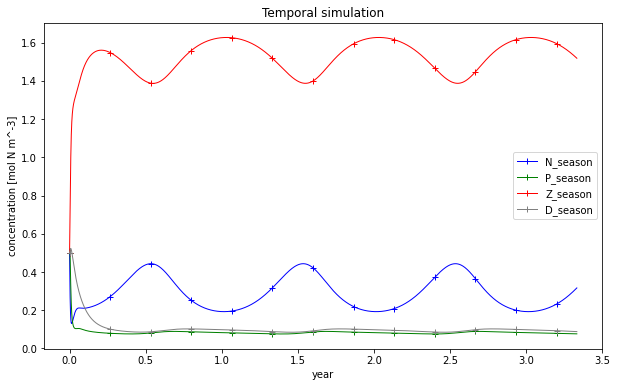

In [118]:
plt.figure(figsize=(10, 6))
#plt.ylim(0,2)

# Plot llm
plot_npzd(t/360, results.T, name='season', marker='+', every=800, lw=1)



# Labels
plt.title('Temporal simulation')
plt.xlabel('year')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

In [11]:
# OLD CODE EULER DERIVS

def compute_derivatives(N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki):
    derivatives=[]
    Nderivative=-phyto_growth(mum,kn,ki,N,I)*P+phiz*Z+gammam*D
    derivatives.append(Nderivative)
    Pderivative=(phyto_growth(mum,kn,ki,N,I)-phip)*P-grazing_growth(g,epsilon,P)*Z
    derivatives.append(Pderivative)
    Zderivative=(beta*grazing_growth(g,epsilon,P)-phiz-phizqua*Z)*Z
    derivatives.append(Zderivative)
    Dderivative=phip*P+((1-beta)*grazing_growth(g,epsilon,P)+phizqua*Z)*Z-gammam*D
    derivatives.append(Dderivative)
    return derivatives

def run_LLM(N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki):
    J = phyto_growth(mum,kn,ki,N,I)
    G = grazing_growth(g,epsilon,P)
    derivatives = []
    
    Nderivative = -J*P+phiz*Z+gammam*D
    derivatives.append(Nderivative)
    Pderivative = (J-phip)*P-G*Z
    derivatives.append(Pderivative)
    Zderivative = (beta*G-phiz)*Z
    derivatives.append(Zderivative)
    Dderivative= phip*P+(1-beta)*G*Z-gammam*D
    derivatives.append(Dderivative)
    return derivatives

def run_LQM(N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki):
    J = phyto_growth(mum,kn,ki,N,I)
    G = grazing_growth(g,epsilon,P)
    derivatives = []
    
    Nderivative = -J*P+phiz*Z+gammam*D
    derivatives.append(Nderivative)
    Pderivative = (J-phip)*P-G*Z
    derivatives.append(Pderivative)
    Zderivative = (beta*G-phiz-phizqua*Z)*Z
    derivatives.append(Zderivative)
    Dderivative= phip*P+((1-beta)*G+phizqua*Z)*Z-gammam*D
    derivatives.append(Dderivative)
    return derivatives

def solution_euler(model,N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep):
    if model == 'llm':
        derivatives=run_LLM(N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki)
    elif model == 'lqm':
        derivatives=run_LQM(N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki)
        
    Nt=N+timestep*derivatives[0]
    Pt=P+timestep*derivatives[1]
    Zt=Z+timestep*derivatives[2]
    Dt=D+timestep*derivatives[3]
    return Nt,Pt,Zt,Dt

def model(model,N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep,num_iter):
    N_vec=[]
    P_vec=[]
    Z_vec=[]
    D_vec=[]
    N_vec.append(N)
    P_vec.append(P)
    Z_vec.append(Z)
    D_vec.append(D)
    No=N
    Po=P
    Zo=Z
    Do=D
    for i in range(num_iter):
        Nt,Pt,Zt,Dt=solution_euler(model,No,Po,Zo,Do,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep)
        N_vec.append(Nt)
        P_vec.append(Pt)
        Z_vec.append(Zt)
        D_vec.append(Dt)
        No=Nt
        Po=Pt
        Zo=Zt
        Do=Dt
    return N_vec,P_vec,Z_vec,D_vec

In [371]:
for i in range(0,100000,5000):
        xran = 5000
        dif = np.abs(N_vec[i]-N_vec[i+xran])/N_vec[i]
        if dif < 0.0005:
            print(f"\n{N_vec[-1]} It converges at {dif, i}")
for i in range(0,100000,5000):
        xran = 5000
        dif = np.abs(D_vec[i]-D_vec[i+xran])/D_vec[i]
        print(dif)
        if dif < 0.0005:
            print(f"\n{D_vec[-1]} It converges at {dif, i}")


0.7902699636085939 It converges at (0.00021684535551031743, 20000)

0.7902699636085939 It converges at (2.9831967200973005e-05, 25000)

0.7902699636085939 It converges at (4.098058161516678e-06, 30000)

0.7902699636085939 It converges at (5.628321033688419e-07, 35000)

0.7902699636085939 It converges at (7.729753978430724e-08, 40000)

0.7902699636085939 It converges at (1.0615747472153406e-08, 45000)

0.7902699636085939 It converges at (1.4579164724161593e-09, 50000)

0.7902699636085939 It converges at (2.002263511204262e-10, 55000)

0.7902699636085939 It converges at (2.7500523557429816e-11, 60000)

0.7902699636085939 It converges at (3.776278522028088e-12, 65000)

0.7902699636085939 It converges at (6.142072060405188e-13, 70000)

0.7902699636085939 It converges at (8.93494471733783e-14, 75000)

0.7902699636085939 It converges at (0.0, 80000)

0.7902699636085939 It converges at (0.0, 85000)

0.7902699636085939 It converges at (0.0, 90000)

0.7902699636085939 It converges at (0.0, 950

In [400]:
# MAKE THIS CLEARER

# Model values
Cref=1.066 # Growth coefficient of phytoplancton
c=1 # Growth coefficient of phytoplancton
beta=0.925 # Assimilation coefficient of zooplankton
alpha=0.256 # Slope of photoshynthesis vs linght intensity
mum=0.870 # Phytoplancton growth rate
phip=0.04 # Phytoplancton linear mortality
phipqua=0.25 # Phytoplancton quadratic mortality
epsilon=1.6 # Grazing encounter rate
g=1.575 # Maximum grazing rate
phiz=0.01 # Phytoplancton linear mortality
phizqua=0.34 # Phytoplancton quadratic mortality
gammam=0.048 # Detritus remineralization rate
kn=0.7 # Half saturation constant for NO3 uptake
ki=0.5 # Half saturation constant for light

I=8 # Light initial value

# Simulation values
timestep=0.01
num_iter=100000

In [404]:
# Initial values
index = []
convs = [[],[],[],[]]
convs1 = [[],[],[],[]]
for i in np.arange(0.01, 35, 0.8):
    S = i
    N,P,Z,D = 1,1,1,1
    norm = S/(N+P+Z+D)
    N= N * norm # Nutrients
    P= P * norm # Phytoplancton
    Z= Z * norm # Zooplancton
    D= D * norm # Detritus

    N_vec,P_vec,Z_vec,D_vec=model('llm',N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep,num_iter)   
    N_vec1,P_vec1,Z_vec1,D_vec1=model('lqm',N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep,num_iter)   

    index.append(i)
    convs[0].append(N_vec[-1]) 
    convs[1].append(P_vec[-1]) 
    convs[2].append(Z_vec[-1]) 
    convs[3].append(D_vec[-1]) 
    convs1[0].append(N_vec1[-1]) 
    convs1[1].append(P_vec1[-1]) 
    convs1[2].append(Z_vec1[-1]) 
    convs1[3].append(D_vec1[-1]) 


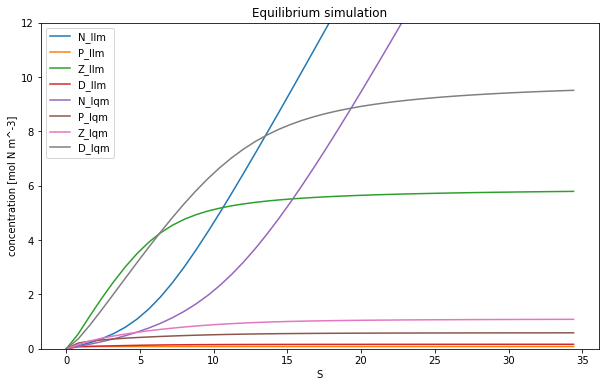

In [405]:
plt.figure(figsize=(10, 6))
plt.title('Equilibrium simulation')
plt.plot(index,convs[0],label="N_llm")
plt.plot(index,convs[1],label="P_llm")
plt.plot(index,convs[2],label="Z_llm")
plt.plot(index,convs[3],label="D_llm")

plt.plot(index,convs1[0],label="N_lqm")
plt.plot(index,convs1[1],label="P_lqm")
plt.plot(index,convs1[2],label="Z_lqm")
plt.plot(index,convs1[3],label="D_lqm")
plt.ylim(0,12)
plt.xlabel('S')
plt.ylabel('concentration [mol N m^-3]')
plt.legend()
plt.show()

In [396]:
S = 0.15
N,P,Z,D = 1,1,1,1
norm = S/(N+P+Z+D)
N= N * norm # Nutrients
P= P * norm # Phytoplancton
Z= Z * norm # Zooplancton
D= D * norm # Detritus

N_vec1,P_vec1,Z_vec1,D_vec1=model('llm',N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep,num_iter)   
N_vec2,P_vec2,Z_vec2,D_vec2=model('lqm',N,P,Z,D,I,beta,mum,phip,phipqua,epsilon,g,phiz,phizqua,gammam,kn,ki,timestep,num_iter)   


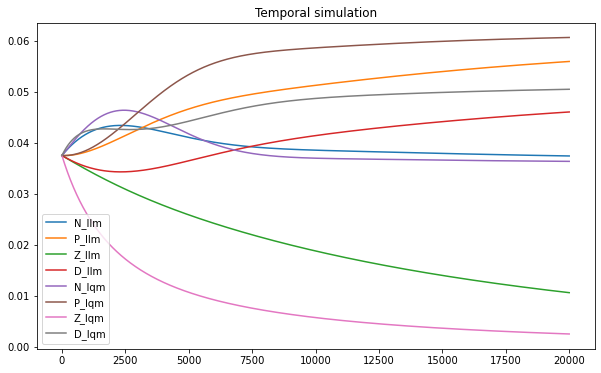

In [397]:
plt.figure(figsize=(10, 6))
plt.title('Temporal simulation')
ix = np.arange(num_iter+1)
plt.plot(ix[:20000], N_vec1[:20000],label="N_llm")
plt.plot(ix[:20000], P_vec1[:20000],label="P_llm")
plt.plot(ix[:20000], Z_vec1[:20000],label="Z_llm")
plt.plot(ix[:20000], D_vec1[:20000],label="D_llm")
plt.plot(ix[:20000], N_vec2[:20000],label="N_lqm")
plt.plot(ix[:20000], P_vec2[:20000],label="P_lqm")
plt.plot(ix[:20000], Z_vec2[:20000],label="Z_lqm")
plt.plot(ix[:20000], D_vec2[:20000],label="D_lqm")
plt.legend()
plt.show()

In [212]:
utomatic convergence detector
#
vec = D_vec
for i in range(0,100000,5000):
    shift = i
    xran = 5000
    size = len(vec)
    print(i,i+xran, vec[i], end=' \n')
    dif = np.abs(vec[i]-vec[i+xran])/N_vec[i]
    disp = np.var(vec[i:i+xran])/np.mean(vec[i:i+xran])
    if dif < 0.0001:
        print(f"\nIt converges at {vec[i+xran], disp, dif, i}")
        break
    if disp < 0.00001:
        print(f"\nIt converges at {vec[i+xran], disp, dif, i}")
        break
    #print(, dif, end=' \n')
    #a=np.var(D_vec[90000:99500])

0 5000 0.25 
5000 10000 0.09310631155146806 
10000 15000 0.07502751385391661 

It converges at (0.07574630225862905, 8.18874500145404e-07, 0.0014866128192915036, 10000)


In [ ]:
def model(S,t):
    return ()

### Misc

Implementation of a predator prey model

$\begin{cases} \dot{N}=N*(a-b*P) \\ \dot{P}=P*(c*N-d) \end{cases}$

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [147]:
# Data containers
n_steps = 10000*3
N = np.zeros(n_steps)
P = np.zeros(n_steps)
# Initial values
N[0] = 0.2
P[0] = 0.8

In [148]:
dt = 0.0001

In [149]:
# Params
a = 60
b = 180
c = 80
d = 20

In [151]:
for i in range(n_steps-1):
    dn = N[i]*(a-b*P[i])
    dp = P[i]*(c*N[i]-d)
    if np.isinf(dn):
        print(i)
        break
    N[i+1] = N[i]*(1+dn*dt)
    P[i+1] = P[i]*(1+dp*dt)

First constant: 0.33, second constant: 0.25


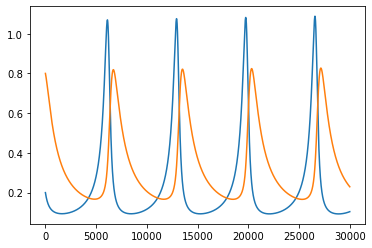

In [156]:
# TODO: Improve visualizations
print(f"First constant: {a/b:.2f}, second constant: {d/c:.2f}")
plt.plot(N[:i])
plt.plot(P[:i])